# Calibrating TTim model to hypothetical pumping test

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ttim import *

### Use observation times from Oude Korendijk

In [2]:
drawdown = np.loadtxt('data/oudekorendijk_h30.dat')
tobs = drawdown[:,0] / 60 / 24
robs = 30
Q = 788

### Generate data

In [3]:
ml = ModelMaq(kaq=60, z=(-18, -25), Saq=1e-4, tmin=1e-5, tmax=1)
w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0)
ml.solve()
np.random.seed(2)
hobs = ml.head(robs, 0, tobs)[0] + 0.05 * np.random.randn(len(tobs))

self.neq  1
solution complete


### See if TTim can find aquifer parameters back

In [4]:
cal = Calibrate(ml)
cal.set_parameter(name='kaq0', initial=100)
cal.set_parameter(name='Saq0', initial=1e-3)
cal.series(name='obs1', x=robs, y=0, layer=0, t=tobs, h=hobs)
cal.fit()

............................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 34
    # variables        = 2
    chi-square         = 0.09714912
    reduced chi-square = 0.00303591
    Akaike info crit   = -195.167536
    Bayesian info crit = -192.114815
[[Variables]]
    kaq0:  59.5331900 +/- 2.36790654 (3.98%) (init = 100)
    Saq0:  9.2405e-05 +/- 1.2516e-05 (13.54%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.851


In [5]:
cal.parameters

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,59.5332,2.367907,3.97746,-inf,inf,100,[59.53319002210707]
Saq0,9.24053e-05,0.000013,13.5447,-inf,inf,0.001,[9.240529867448516e-05]


In [6]:
print('rmse:', cal.rmse())

rmse: 0.05345397106082128


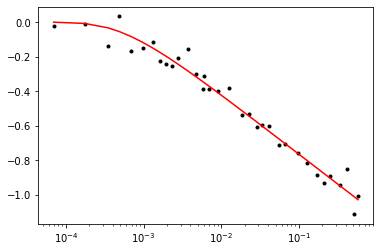

In [7]:
hm = ml.head(robs, 0, tobs, 0)
plt.semilogx(tobs, hobs, '.k')
plt.semilogx(tobs, hm[0], 'r')

In [8]:
print('correlation matrix')
print(cal.fitresult.covar)

correlation matrix
[[ 5.60698139e+00 -2.52171428e-05]
 [-2.52171428e-05  1.56651901e-10]]


Fit with `scipy.least_squares` (not recommended)

In [9]:
cal = Calibrate(ml)
cal.set_parameter(name='kaq0', initial=100)
cal.set_parameter(name='Saq0', initial=1e-3)
cal.series(name='obs1', x=robs, y=0, layer=0, t=tobs, h=hobs)
cal.fit_least_squares(report=True)

......................................................
         optimal       std perc_std  pmin  pmax initial  \
kaq0     59.5334  2.339157  3.92915  -inf   inf     100   
Saq0  9.2398e-05  0.000012  13.4157  -inf   inf   0.001   

                      parray  
kaq0     [59.53335695354822]  
Saq0  [9.23979769151393e-05]  
[2.33915730e+00 1.23958453e-05]
[[ 5.47165689e+00 -2.46555615e-05]
 [-2.46555615e-05  1.53656981e-10]]
[[ 1.         -0.85031398]
 [-0.85031398  1.        ]]


## Calibrate parameters in multiple layers
Example showing how parameters can be optimized when multiple layers share the same parameter value.

In [10]:
ml = ModelMaq(kaq=[10., 10.], z=(-10, -16, -18, -25), c=[10.], Saq=[0.1, 1e-4], tmin=1e-5, tmax=1)
w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=1)
ml.solve()
hobs0 = ml.head(robs, 0, tobs, layers=[0])[0]
hobs1 = ml.head(robs, 0, tobs, layers=[1])[0]

self.neq  1
solution complete


In [11]:
cal.parameters

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,59.5334,2.339157,3.92915,-inf,inf,100,[59.53335695354822]
Saq0,9.2398e-05,0.000012,13.4157,-inf,inf,0.001,[9.23979769151393e-05]


In [12]:
cal = Calibrate(ml)
cal.set_parameter(name='kaq0_1', initial=20., pmin=0., pmax=30.)  # layers 0 and 1 have the same k-value
cal.set_parameter(name='Saq0', initial=1e-3, pmin=1e-5, pmax=0.2)
cal.set_parameter(name='Saq1', initial=1e-3, pmin=1e-5, pmax=0.2)
cal.set_parameter(name='c1', initial=1., pmin=0.1, pmax=200.)
cal.series(name='obs0', x=robs, y=0, layer=0, t=tobs, h=hobs0)
cal.series(name='obs1', x=robs, y=0, layer=1, t=tobs, h=hobs1)
cal.fit(report=False)
display(cal.parameters)

..............................................................................................
Fit succeeded.


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_1,10.002821,7.760404e-04,0.007758,0.00000,30.0,20.000,"[10.00282083843134, 10.00282083843134]"
Saq0,0.099977,1.029338e-06,0.001030,0.00001,0.2,0.001,[0.09997723703792818]
Saq1,0.000100,2.783601e-09,0.002783,0.00001,0.2,0.001,[0.00010001141042525883]
c1,10.000832,2.330321e-04,0.002330,0.10000,200.0,1.000,[10.000832122134655]


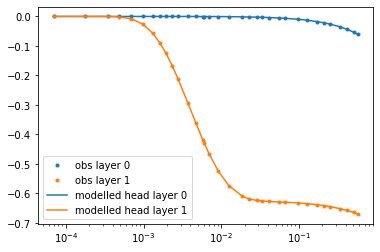

In [13]:
plt.semilogx(tobs, hobs0, '.C0', label="obs layer 0")
plt.semilogx(tobs, hobs1, '.C1', label="obs layer 1")

hm = ml.head(robs, 0, tobs)
plt.semilogx(tobs, hm[0], 'C0', label="modelled head layer 0")
plt.semilogx(tobs, hm[1], 'C1', label="modelled head layer 1")

plt.legend(loc="best")

### Generate data for head measured in well

In [9]:
tobs2 = np.hstack((tobs, np.arange(0.61, 1, 0.01)))

In [12]:
ml = ModelMaq(kaq=60, z=(-18, -25), Saq=1e-4, tmin=1e-5, tmax=1)
w = Well(ml, xw=0, yw=0, rw=0.3, res=0.02, tsandQ=[(0, 788), (0.6, 0)], layers=0)
ml.solve()
np.random.seed(2)
hobs2 = w.headinside(tobs2)[0] + 0.05 * np.random.randn(len(tobs2))

self.neq  1
solution complete


In [13]:
cal = Calibrate(ml)
cal.set_parameter(name='kaq0', initial=100)
cal.set_parameter(name='Saq0', initial=1e-3)
cal.set_parameter_by_reference(name='res', parameter=w.res[:], initial=0.05)
cal.seriesinwell(name='obs1', element=w, t=tobs2, h=hobs2)
cal.fit()

..................................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 143
    # data points      = 73
    # variables        = 3
    chi-square         = 0.17064806
    reduced chi-square = 0.00243783
    Akaike info crit   = -436.278631
    Bayesian info crit = -429.407253
[[Variables]]
    kaq0:  60.2257029 +/- 1.32915917 (2.21%) (init = 100)
    Saq0:  0.00144777 +/- 0.00829132 (572.70%) (init = 0.001)
    res:   0.02699969 +/- 0.01388099 (51.41%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(Saq0, res)  =  1.000
    C(kaq0, Saq0) = -0.530
    C(kaq0, res)  = -0.506


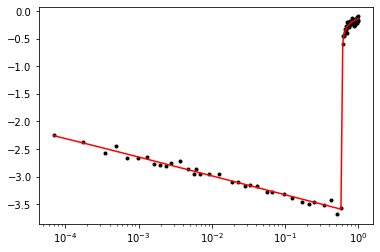

In [15]:
hm = w.headinside(tobs2)
plt.semilogx(tobs2, hobs2, '.k')
plt.semilogx(tobs2, hm[0], 'r')